## Supplement 4: Classification

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import mode



### 4.2 Programming Task: K-Nearest Neighbor
The datasets in files __train-knn.csv__ and __test-knn.csv__ contain samples from a synthetic dataset for training a K-Nearest Neighbor classifier.
The dataset consists of 7 columns: the first six columns, denoted as x1, x2, ..., x6 represent
 the input features for each data sample, and the last column represents the class label given by 0 or 1.
There are 200 samples in the __train-knn.csv__ and 100 samples in the __test-knn.csv__}.

i\. Implement the K-Nearest Neighbor classification algorithm using NumPy and SciPy.



In [2]:
train_set = pd.read_csv('train-knn.csv').to_numpy()
test_set = pd.read_csv('test-knn.csv').to_numpy()
# Last column is class labels
train_X = train_set[:,:-1]
train_y = train_set[:,-1]

test_X = test_set[:,:-1]
test_y = test_set[:,-1]


Discussion Questions:

1.1 What is the primary purpose of splitting the dataset into X (features) and y (labels)?
   - a) To save memory during computation
   - b) To separate input variables from the target variable we want to predict
   - c) To make the code more organized
   - d) To increase computational speed


In [4]:

def knn_predict(train_X,train_y, test_X,n):

    
    distance_matrix = cdist(train_X,test_X,)
    
    neighbour_indices = distance_matrix.argsort(axis=0)[:n]
    
    neighbour_class = train_y[neighbour_indices]
    
    frequent_class,_ = mode(neighbour_class,axis=0)


    return frequent_class.reshape(-1,)


In [8]:

# Using a subset of the original dataset
predicted_y = knn_predict(train_X[:8],train_y[:8],test_X[:5],n=2)
print('predictions: ',predicted_y)
print('true labels: ',test_y[:5])





predictions:  [1. 0. 0. 0. 0.]
true labels:  [0. 0. 0. 1. 1.]


ii\. Perform cross-validation (with 5 folds) on the train dataset __train-knn.csv__ to determine a suitable value of K.


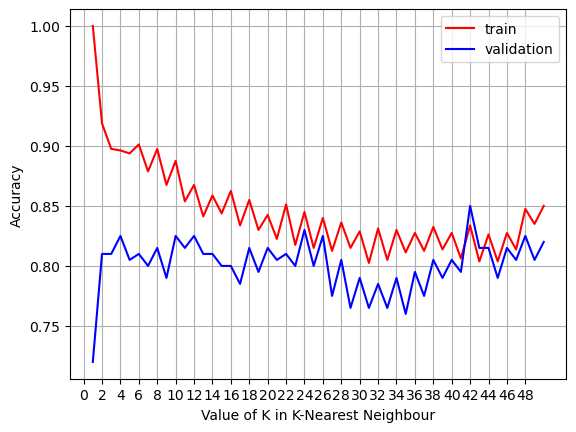

best k from cross validation: 42


k,train_acc,val_acc
42,0.833750,0.850000
24,0.845000,0.830000
48,0.847500,0.825000
26,0.840000,0.825000
10,0.887500,0.825000


In [10]:

def get_accuracy(predict_labels,true_labels):
    correct_count = np.sum([predict_labels==true_labels])
    total_samples = predict_labels.shape[0]

    accuracy = correct_count / total_samples

    return accuracy
random_seed = 8
np.random.seed(random_seed)

n_fold = 5

train_size = train_set.shape[0]
indices = np.arange(train_size)
np.random.shuffle(indices)

# split dataset 
splits = np.array_split(indices, n_fold)

# List to store metrics for each value of k
exp = []


k_max= 50
for k in range(1,k_max+1):
    
    val_acc = np.zeros(n_fold)
    train_acc = np.zeros(n_fold)

    for fold in range(n_fold):
        val_indices = splits[fold]

        # Create a mask that has 1 at val_set indices and 0 elsewhere
        mask = np.zeros(train_size,dtype=bool)
        mask[val_indices] = True

        # Get val data using mask
        val = train_set[mask]

        # Get train data by inverting the mask
        train = train_set[np.invert(mask)]

        # Last column is class labels
        cv_train_X = train[:,:-1]
        cv_train_y = train[:,-1]

        cv_val_X=val[:,:-1]
        cv_val_y=val[:,-1]

        # Train accuracy
        predicted_labels_train = knn_predict(cv_train_X,cv_train_y, cv_train_X,k)
        train_acc[fold] = get_accuracy(predicted_labels_train,cv_train_y)

        # Validation accuracy
        predicted_labels_val = knn_predict(cv_train_X,cv_train_y, cv_val_X,k)
        val_acc[fold] = get_accuracy(predicted_labels_val,cv_val_y)

    exp.append([k,train_acc.mean(),val_acc.mean()])

# print(np.argmax(exp))

exp = pd.DataFrame(exp, columns=['k','train_acc','val_acc'])

import matplotlib.pyplot as plt
plt.plot(exp['k'],exp['train_acc'],'r',label='train')
plt.plot(exp['k'],exp['val_acc'],'b',label='validation')
plt.grid()
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Value of K in K-Nearest Neighbour')
plt.xticks(np.arange(0, k_max, step=2))
# plt.plot(train_exp[1:])
plt.show()


exp.sort_values(by=['val_acc'],ascending=False,inplace=True)


best_k = int(exp.iloc[0]['k'])
print('best k from cross validation:',best_k)

exp.head().style.hide(axis='index')

  

iii\. Using the optimal value of k from the cross-validation, obtain the accuracy of your model on the test dataset __test-knn.csv__.


In [22]:

predicted_labels = knn_predict(train_set[:,:-1], train_set[:,-1], test_set[:,:-1],best_k)
acc = get_accuracy(predicted_labels,test_set[:,-1])
print(acc)


0.73


/tmp/ipykernel_1485854/47270101.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  frequent_class,_ = mode(neighbour_class,axis=0)


iv\. Compare your result with the KNeighborsClassifier model from the scikit-learn library.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(train_set[:,:-1], train_set[:,-1])

print(model.score(test_set[:,:-1],test_set[:,-1]))





0.73


In [25]:
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=KFold(5,shuffle=True,random_state=random_seed))
#fit model to data
knn_gscv.fit(train_X, train_y)

print('best k: ',knn_gscv.best_params_['n_neighbors'])
model = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'])
model.fit(train_set[:,:-1], train_set[:,-1])
print('Accurtacy for k=%s : %s' %(knn_gscv.best_params_['n_neighbors'],model.score(test_set[:,:-1],test_set[:,-1])))

best k:  42
Accurtacy for k=42 : 0.73
